# Apply PCP and sPCP to MVBS data

Here we will use algorithms implemented by [ShunChi100](https://github.com/ShunChi100/RobustPCA/) to apply PCP and sPCP to the MVBS data.

- PCP (Principal Component Pursuit) = RPCA (Robust Pricipal Component Analysis).
- sPCP = sparse PCP.


The package can be installed by:
```
$ pip install fbpca
$ pip install git+https://github.com/ShunChi100/RobustPC
```
Note `fbpca` is required to be installed first. Otherwise you will see a notification to install that first.

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
MVBS_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_MVBS_envFromFile/'
MVBS_file = '20150817-20151017_MVBS_time_from_Sv_rangeBin5_all.nc'

In [3]:
MVBS = xr.open_dataset(os.path.join(MVBS_path, MVBS_file))
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (ping_time, range_bin) float64 ...

Reorder the frequency dimension:

In [123]:
MVBS = MVBS.reindex({'frequency': [38000,120000,200000]})

In [124]:
MVBS_vals = MVBS['MVBS'].values

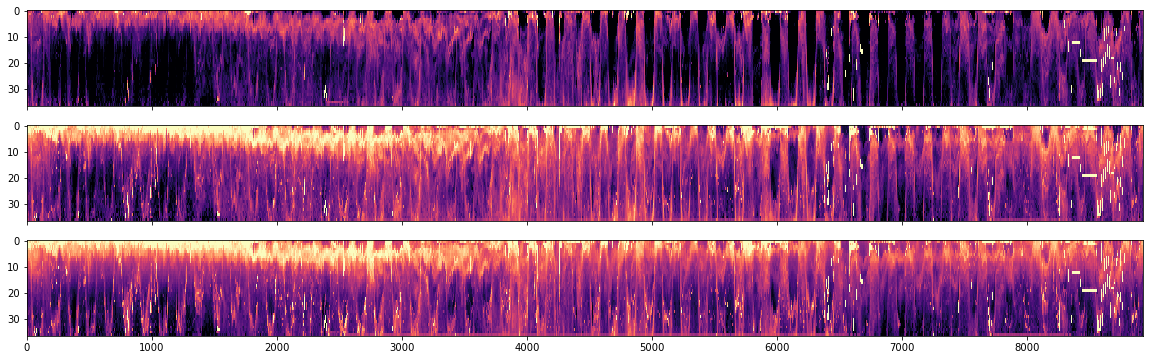

In [156]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(MVBS_vals[37:0:-1,:,iax],
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)

Reshape matrix to allow PCP decomposition:

In [126]:
MVBS_vals_reshape = np.moveaxis(MVBS_vals,[0,1,2],[1,2,0]).reshape(3,41,62,144)

In [127]:
MVBS_vals_reshape.shape

(3, 41, 62, 144)

Sanity check by plotting out day 0:

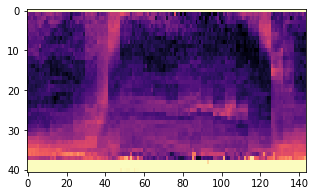

In [128]:
fig, ax = plt.subplots(1,1,figsize=(5,3),sharex=True)
im = plt.imshow(MVBS_vals_reshape[0,:,0,:],aspect='auto',cmap='magma',vmin=-80,vmax=-50)

Further reshape to get to `[62 x 3*144*37]`, note the last number is 37 instead of 41 because we want to exclude the first range_bin immediately above the echosounder and the 3 range bins dominated by the sea surface reflection.

In [129]:
np.moveaxis(MVBS_vals_reshape[:,37:0:-1,:,:],[0,1,2],[1,2,0]).shape

(62, 3, 37, 144)

In [130]:
MVBS_for_PCP = np.moveaxis(MVBS_vals_reshape[:,37:0:-1,:,:],[0,1,2],[1,2,0]).reshape([62,-1])
MVBS_for_PCP.shape

(62, 15984)

## PCP

In [149]:
from RobustPCA.rpca import RobustPCA

In [132]:
rpca = RobustPCA()

Default parameters for `rpca` are:
```python
lamb=None, mu=None, max_rank=None, tol=1e-6, max_iter=100, use_fbpca=False, fbpca_rank_ratio=0.2
```

These parameters are well-documented [in the code](https://github.com/ShunChi100/RobustPCA/blob/master/RobustPCA/rpca.py)

Here we first run the default parameters:

In [133]:
rpca.fit(MVBS_for_PCP)
L_rpca = rpca.get_low_rank()
S_rpca = rpca.get_sparse()

Not converged!
Total error: 15.456207, allowed tolerance: 0.000001


And then increase `max_iter`

In [134]:
rpca = RobustPCA(max_iter=10000)
rpca.fit(MVBS_for_PCP)
L_rpca = rpca.get_low_rank()
S_rpca = rpca.get_sparse()

Converged!


In [135]:
L_rpca.shape

(62, 15984)

In [136]:
L_rpca.reshape(62,3,37,144).shape

(62, 3, 37, 144)

In [143]:
L_rpca_reorg = L_rpca.reshape(62,3,37,144)
S_rpca_reorg = S_rpca.reshape(62,3,37,144)

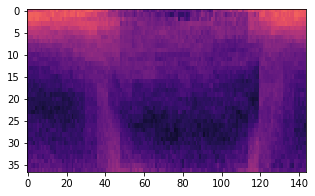

In [138]:
fig, ax = plt.subplots(1,1,figsize=(5,3),sharex=True)
im = plt.imshow(L_rpca_reorg[0,0,:,:],aspect='auto',cmap='magma',vmin=-80,vmax=-50)

Let's use the unfolding function from `tensorly` to help with reshaping the decomposed data back for plotting:

In [139]:
import tensorly as tl

### Low-rank component

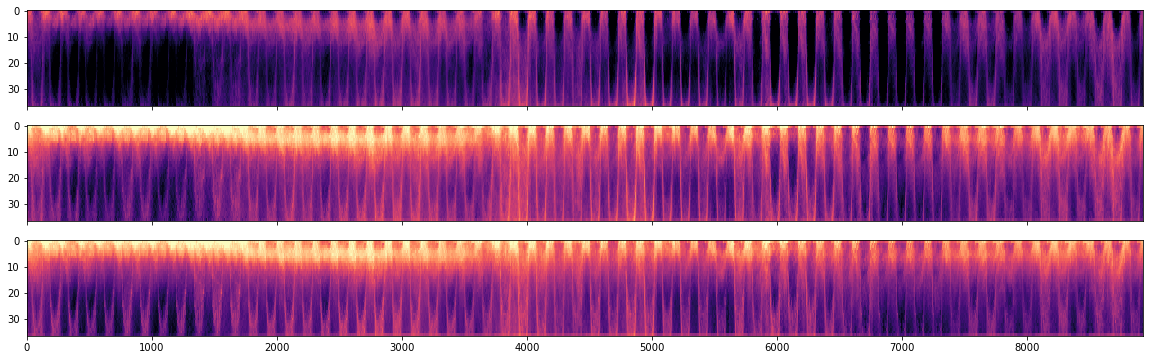

In [141]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(L_rpca_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)

### Sparse component

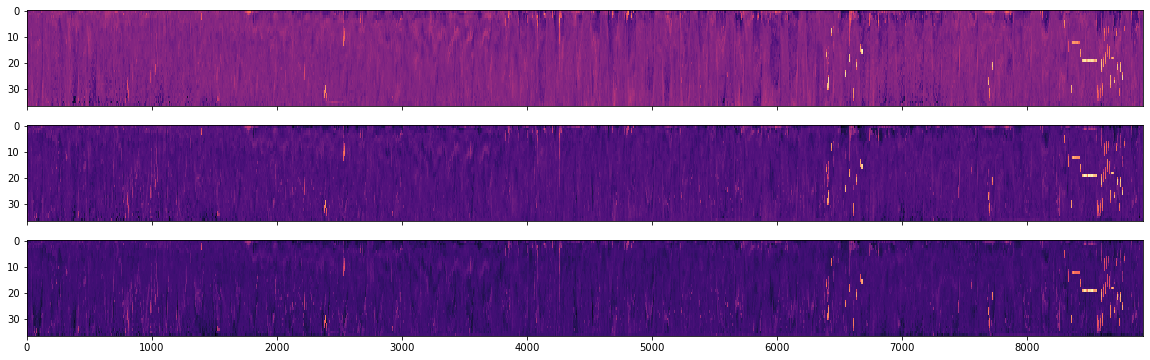

In [148]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(S_rpca_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='magma')

## Sparse PCP

In [150]:
from RobustPCA.spcp import StablePCP

Again as before let's increase `max_iter` to ensure the decomposition runs to convergence under the default tolerance level of 1e-6.

In [151]:
spcp = StablePCP(max_iter=10000)
spcp.fit(MVBS_for_PCP)
L_spcp = spcp.get_low_rank()
S_spcp = spcp.get_sparse()

Converged!


We can reshape the low-rank and sparse components similarly following what we did for PCP results:

In [152]:
L_spcp_reorg = L_spcp.reshape(62,3,37,144)
S_spcp_reorg = S_spcp.reshape(62,3,37,144)

### Low-rank component

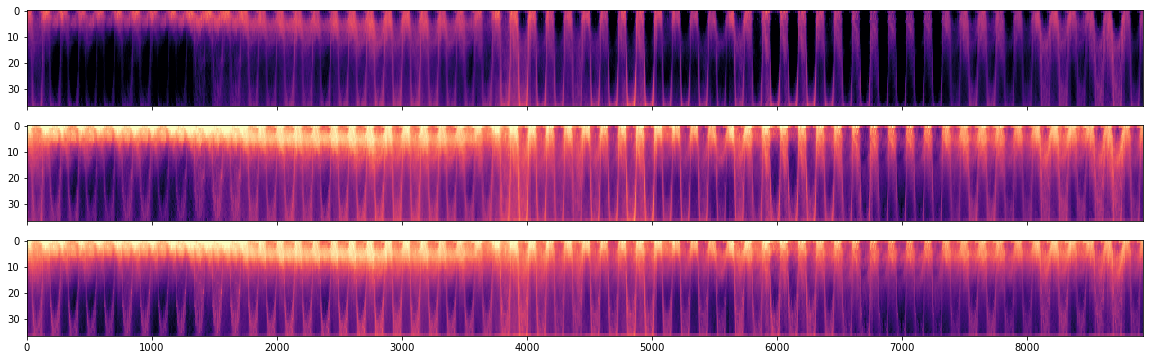

In [153]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(L_spcp_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)

### Sparse component

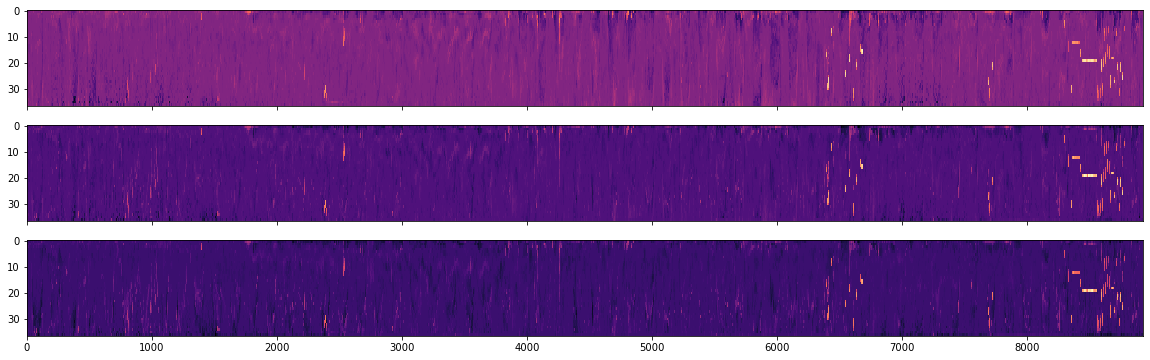

In [154]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(S_spcp_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='magma')